In [1]:
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Install necessary libraries
#!pip install torch torchvision

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


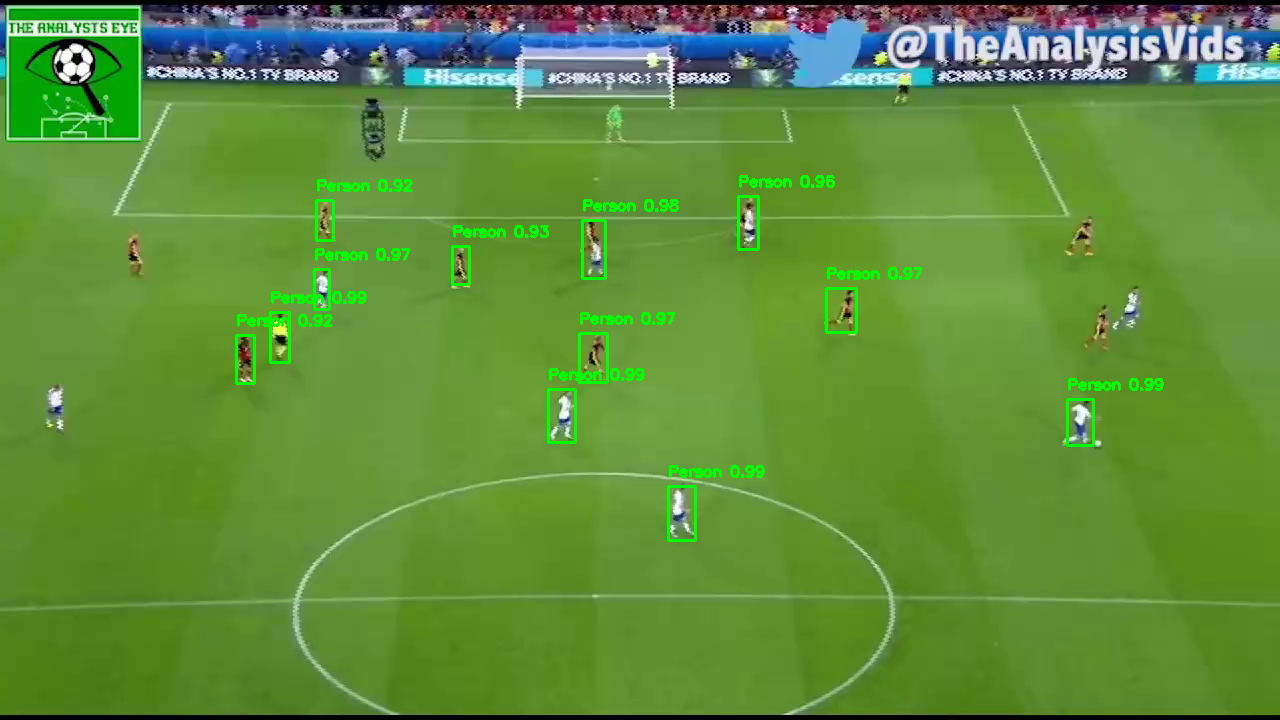

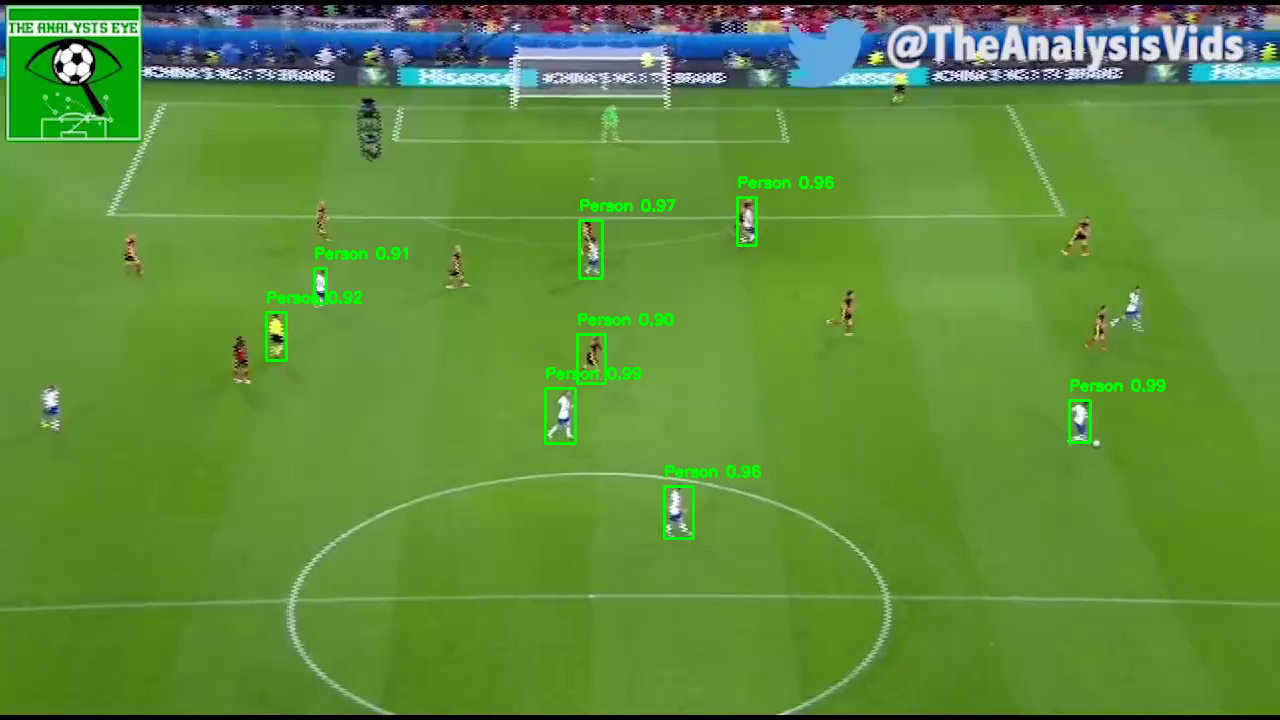

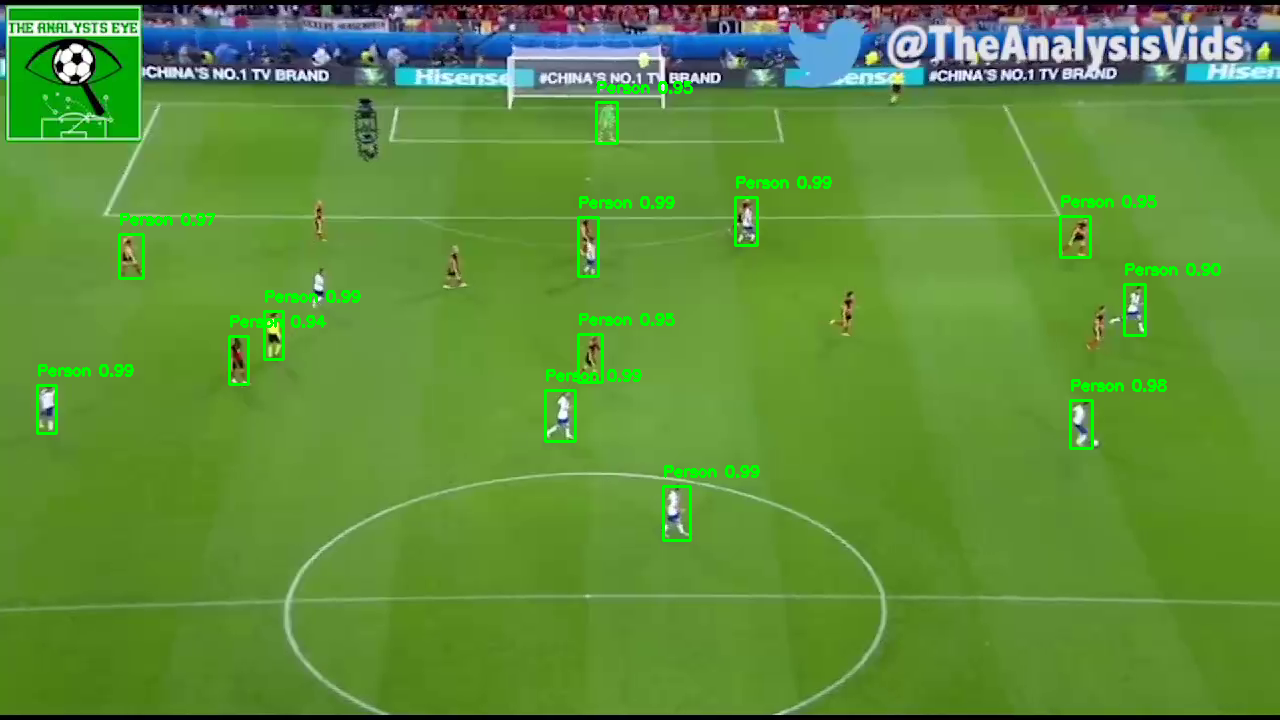

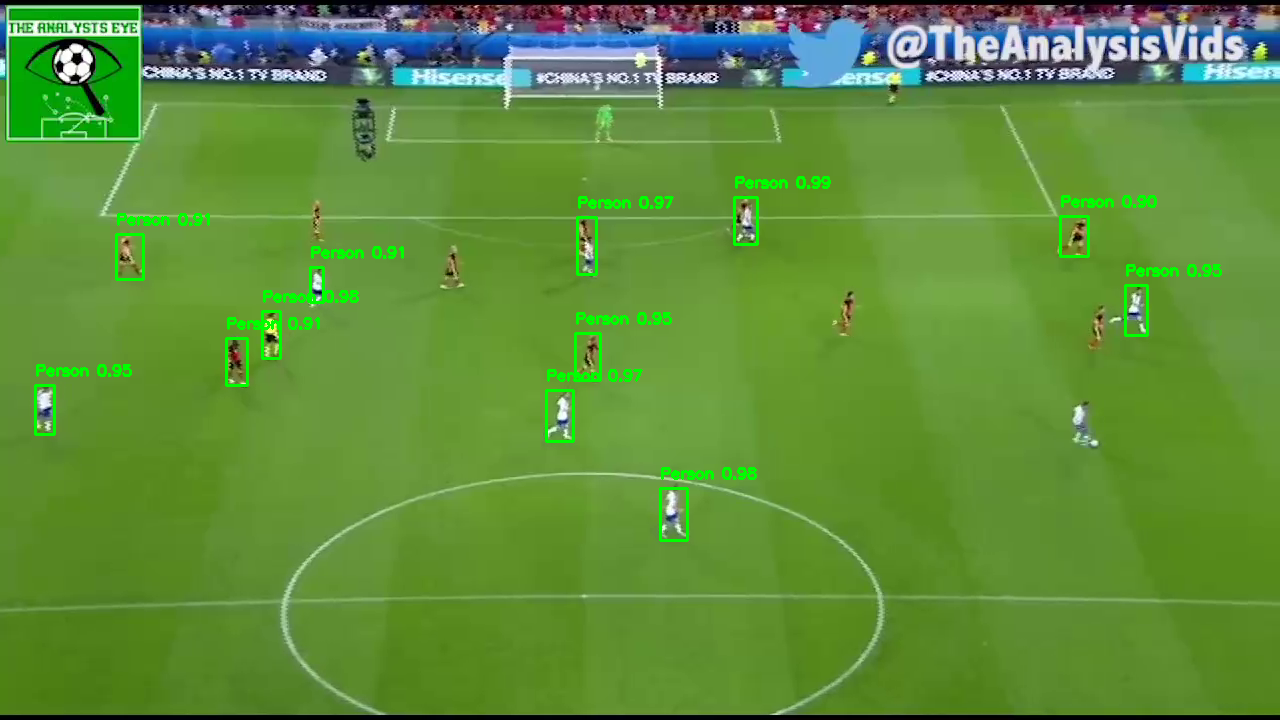

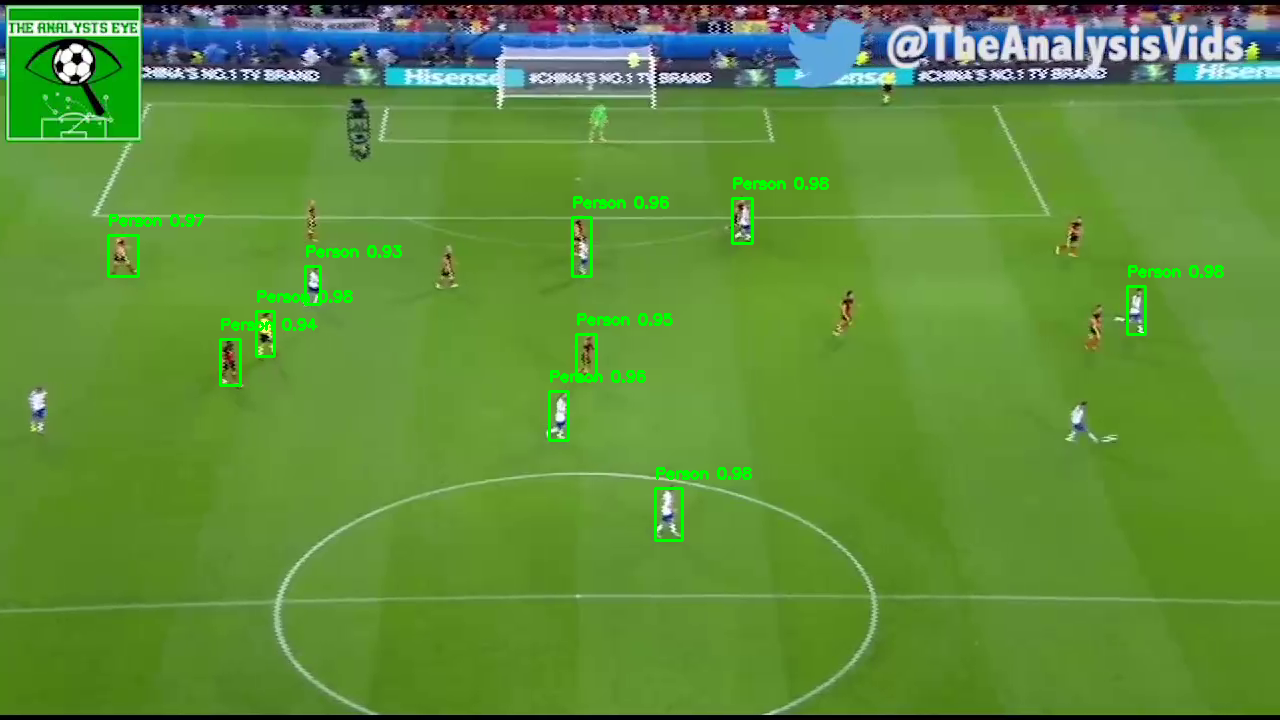

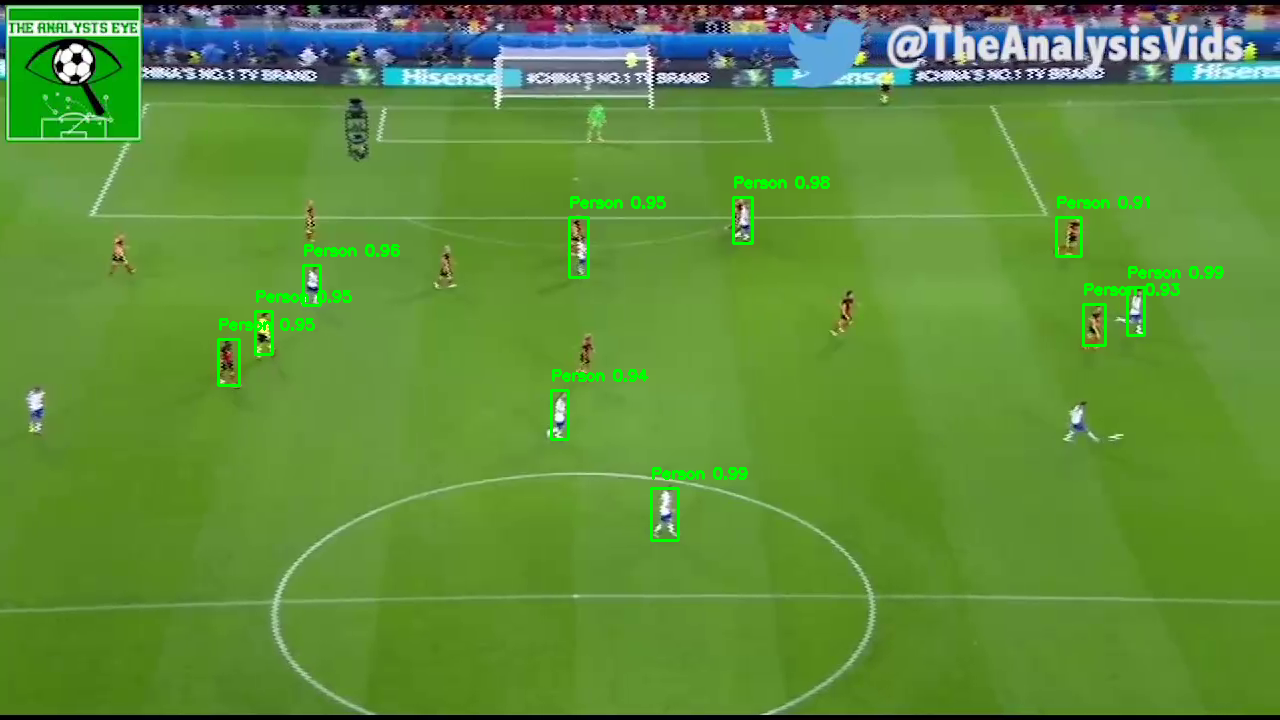

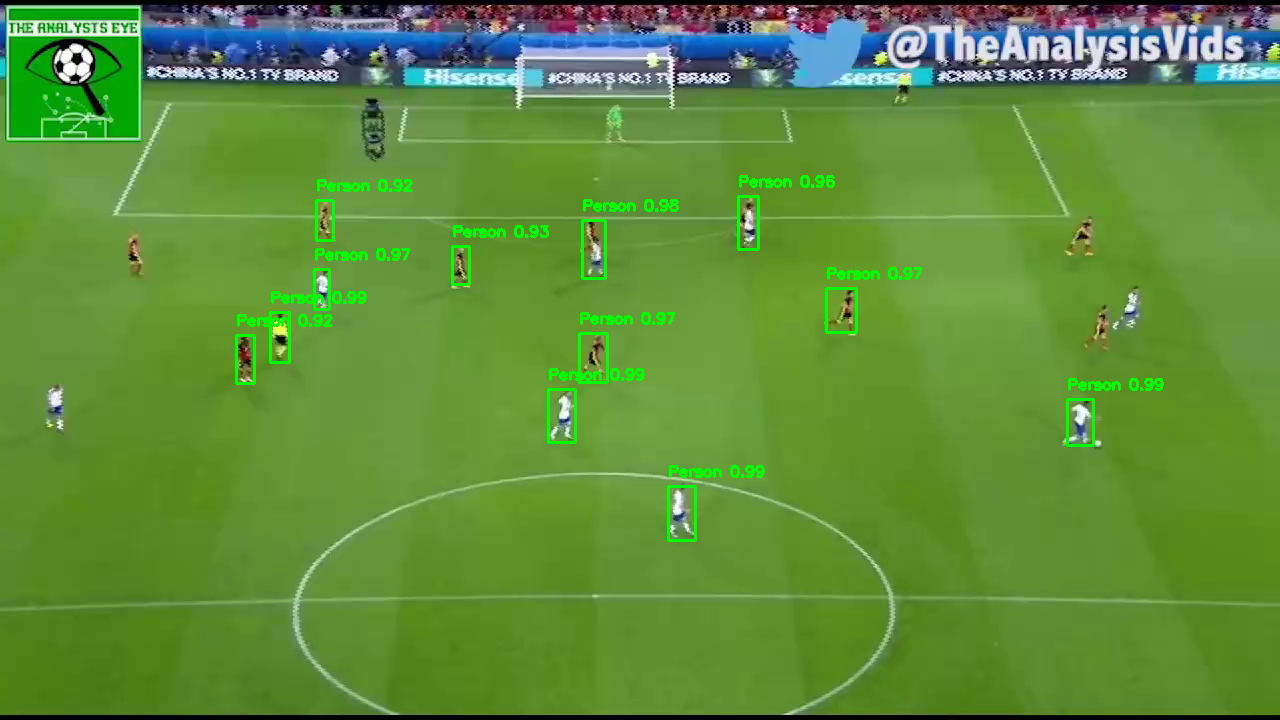

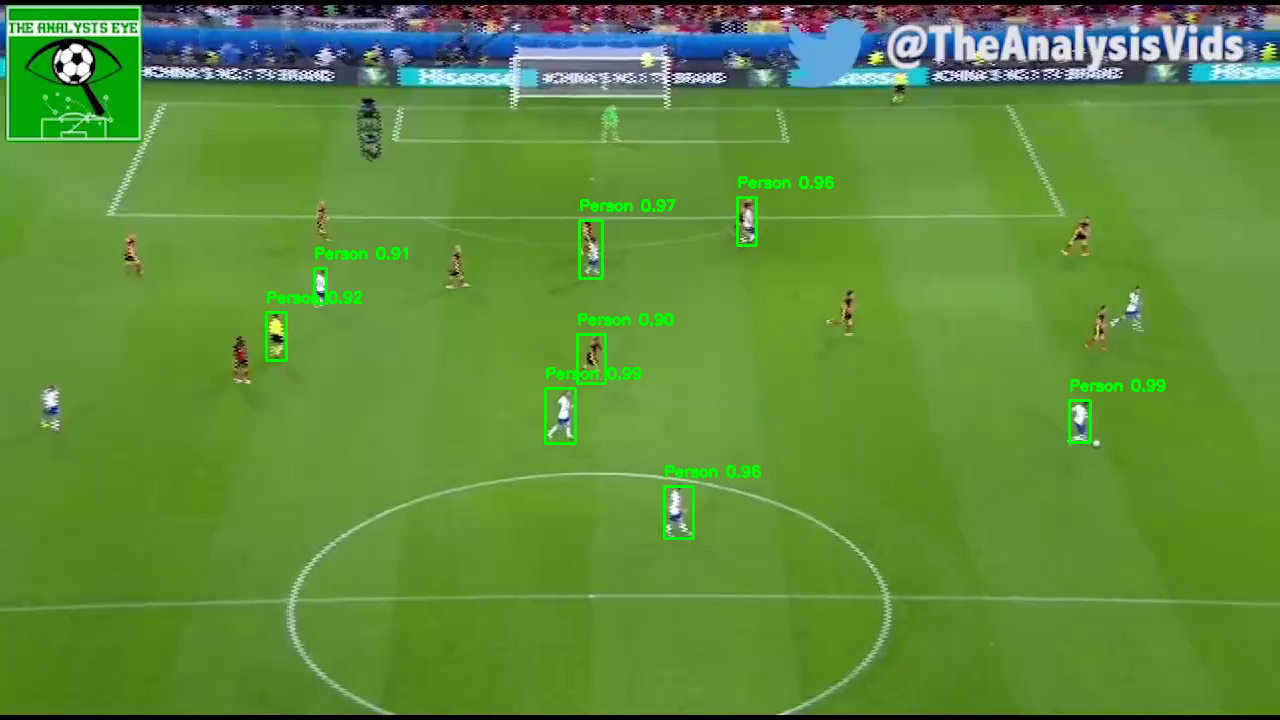

In [3]:


import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np
from PIL import Image as PILImage
from IPython.display import display
import os

# Create output directory if it doesn't exist
output_dir = '/content/drive/MyDrive/football_players_detection/outputs'
os.makedirs(output_dir, exist_ok=True)

# Load the pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Path to your video
video_path = '/content/drive/MyDrive/football_players_detection/video.mp4'

# Load the video
cap = cv2.VideoCapture(video_path)

# Confidence threshold for displaying detections
confidence_threshold = 0.9  # Adjust to see if it improves results

# Frame counter
frame_counter = 0
max_images = 6  # Limit to 6 images

# Process the video frame by frame
while cap.isOpened() and frame_counter < max_images:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to PIL Image
    image = PILImage.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Convert PIL Image to tensor
    image_tensor = F.to_tensor(image).unsqueeze(0)

    # Perform object detection
    with torch.no_grad():
        outputs = model(image_tensor)

    # Extract results
    pred_boxes = outputs[0]['boxes']
    pred_scores = outputs[0]['scores']
    pred_labels = outputs[0]['labels']

    # Filter detections based on confidence threshold
    filtered_indices = pred_scores >= confidence_threshold
    boxes = pred_boxes[filtered_indices].numpy()
    scores = pred_scores[filtered_indices].numpy()
    labels = pred_labels[filtered_indices].numpy()

    # Draw results on the frame
    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.putText(frame, f'Person {score:.2f}', (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert frame with results to PIL Image format
    frame_with_results = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = PILImage.fromarray(frame_with_results)

    # Save the image
    output_file = os.path.join(output_dir, f'frame_{frame_counter:04d}.png')
    pil_image.save(output_file)

    # Display the image
    display(pil_image)

    # Increment frame counter
    frame_counter += 1

# Release the video capture object
cap.release()
